# Identifiability test
In this noted book we investogate a 'cutting corners calculation' of the main aim of the research. We will determine the the quantity: $$\Delta \chi^{2} \sim \left(C_{l}^{1} - C_{l}^{2}\right)^{T} Cov^{-1}\left[C_{l}^{1}\right]\left(C_{l}^{1} - C_{l}^{2}\right)$$

in which $C_{l}^{1}$ would be corresponding to a cosmology of massless neutrinos, $C_{l}^{2}$ corresponds to the hypothetical cosmology containing a number of massive neutrinos and $Cov^{-1}\left[C_{l}^{1}\right]$ is the inverse of the Gaussian covariance. We will build this up simple and possibly explore more complicated renditions later on.

The idea is to calculate this quantity for multiple cosmologies with different neutrino properties given by $C_{l}^{2}$, compared to the $\Lambda CDM$ cosmology, containing only massless neutrinos. More specifically, we will look at the sensitivity in the auto correlation and cross-correlations of the cCMB lensing tracer with the existing tracers used in the 6x2pt. analysis.
These added correlations/angular power spectra, will make up a total 10x2pt. analysis. The goal of this reearch is to develope a forecasting of this analysis.

$\Delta \chi^{2}$ will give us a measure of the sesitivity of the angular power spectra to the neutrino paramters. This in essence could function as a forecast on the neutrino parameter constraining power of the extended analysis. We can relate the value of $\Delta \chi^{2}$ in a cutting corners way to the p-value $\todo{find anything on this p-value}$ which can give us a measure of the sensitivity:

$$\Delta \chi^{2} \sim p \begin{cases}
\ll 1, & \text{(significant) sensitivity}.\\
\sim 1, & \text{if there is no sensitivity}
\end{cases}
$$

and will thus allow us to say something about the potential of the extension of the 6x2pt, analysis by inclusion of the angular power spectra of the CMB lensing tracer. 

Another goal of this is simply the exploration of these processes, to whitness what is going on behind the scenes of the bigger cosmological piplines like cosmoSIS and firecrown.

----

This calculation has a few important elements that we take under the loop one by one.
We will start with defining the cosmologies that we want to investigate. It is these cosmologies that the angular power spectra will be calculated from.
Since we are concerned with the CMB spectra, we must also be concerned with the binning of the redshift space in between current day and last scattering. The accuracy of the analysis also depends on the binning and the properties of the binning process which we will investigate aswell.

The next element is the Gaussian covariance. In the most general case, the Gaussian covariance is a matrix containing the (co)variance between all angular power spectra in (different) bins.
We will start off simple and define a Gaussian covariance for auto correlated bins, such that the Gaussian covariance is diagonal. Later on, we can explore the complexities of the Gaussian covariance and build up the general case.

With these elements in order, we can perform the simplest version of the identifiability test and get an idea of the bigger picture in a small reduces setting.


An important note to make is that this quantitative test is purely based on the singled-out-effect ogf the neutrino parameters on the angular power spectra. As we know, the effects of the cosmological parameters on the matter power spectrum and therefore the angular power spectra are not unique, as we have seen in the previous notebooks:
- [notebook #1](https://github.com/XanderHenrik/Masters-Project/blob/fadf527a729419f612ee98618f3fcc42747736e1/notebooks/varying_P_k.ipynb)
- [notebook #2](https://github.com/XanderHenrik/Masters-Project/blob/fadf527a729419f612ee98618f3fcc42747736e1/notebooks/varying_C_l.ipynb)

This brief analysis in which we cut corners, does not take one of the biggest motivations for this research into account: namely that the inclusion of the CMB lensing angular power spectra can break the degenereacies between these parameters, allowing for an increased constraint on certain parameters after the breaking of these degeneracies.

In [ ]:
# The required imports:

import numpy as np
import pyccl as ccl
import pylab as plt
import math
import glass.observations
from scipy.stats import chi2
%matplotlib inline


ImportError: /lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /home/xander/anaconda3/envs/new_cclenv/lib/python3.12/site-packages/matplotlib/_c_internal_utils.cpython-312-x86_64-linux-gnu.so)

## Cosmologies
First of all we define the different neutrino based cosmologies.

The neutrino parameters to which cosmology is sensitive, and theoretically/phenomenologically the CMB should be sensitive to are:
- The total sum of neutrino masses, $\sum_{i} m_{\nu, i}$
- The effective number of active neutrino species, $N_{eff}$. In different words, the number of massive/massless neutrinos.

The different cosmologies we define below will mainly be based on these paramters and relative variations on these.


In [2]:
# We define the cosmology:
lcdm_cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)#, Neff=3.044)

# Alternate neutrino cosmologies:
neutrino_cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96, Neff=3.044, m_nu=0.12, mass_split='normal')
zero_mm_cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96, Neff=3.044, m_nu=[0, 0.06, 0.06])
single_nu_cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96, Neff=3.044, m_nu=0.12, mass_split='single')

# The specifics of the angular power spectra:
l = np.arange(20, 750)
# l = np.linspace(20, 1000, 1000) # multipole moments; ensure that these are 1 to 1 such that the multipole binninb can be done well later on
z = np.linspace(0., 3.0, 1000) # redshifts
a = (1./(1+z))[::-1]

# Biases:
bias = 0.95/ccl.growth_factor(lcdm_cosmo, a) # bias
bias_neutrino = 0.95/ccl.growth_factor(neutrino_cosmo, a)
bias_zero_mm = 0.95/ccl.growth_factor(zero_mm_cosmo, a)
bias_single_nu = 0.95/ccl.growth_factor(single_nu_cosmo, a)

m_bias = np.ones_like(z) # Magnification bias
i_a = -0.004 * np.ones_like(z) # Intrinsic alignment amplitude

# Binning:
Define the spectroscopic and photometric bins in which we will specify our angular power spectra.
There are some different practices of binning, for different applications. Here we start with the tomographic redshift binning. This subdivides the redshift space and is done through the use of [glass.observations](https://glass.readthedocs.io/v2023.6/reference/observations.html#rd48878c677a1-1).

We keep in mind that the spectroscopic redshift binning is much more accurate than the photometric redshift binning, shown below. For weak lensing there are some intricacies, namely that the configuration of source and lensing bins must have a certain orientation. This is to be kept in mind with the cross correlations of bins. For the last of the 4 probes, CMB lensing, there is really one bin covering the entire evolution history of the CMB. Since we observe the CMB only at the limit of or possibilities: z = 1100, there is nog redshift contamination. The only thing to keep in mind is the source-lense confguration of bins but this will hardly be relevant for us as we do not consider lensing galaxies beyond z = 1100. (Note that this is physically also not possible since galaxy formation happened in between z = 1100 and z = 0) 

For the other case of binning, we refer to the later part of the notebook, where we bin the angular power spectra ánd the Gaussian covariance. The binning procedure in that case is more intricate and will be touched upon later. The reason for the binning of the angular power spectra and Gaussian covariance can however be disclosed already:
- decreasing the computational cost
- reducing the correlations between the multipoles which is induced by masking in the survey.

But more on this later.

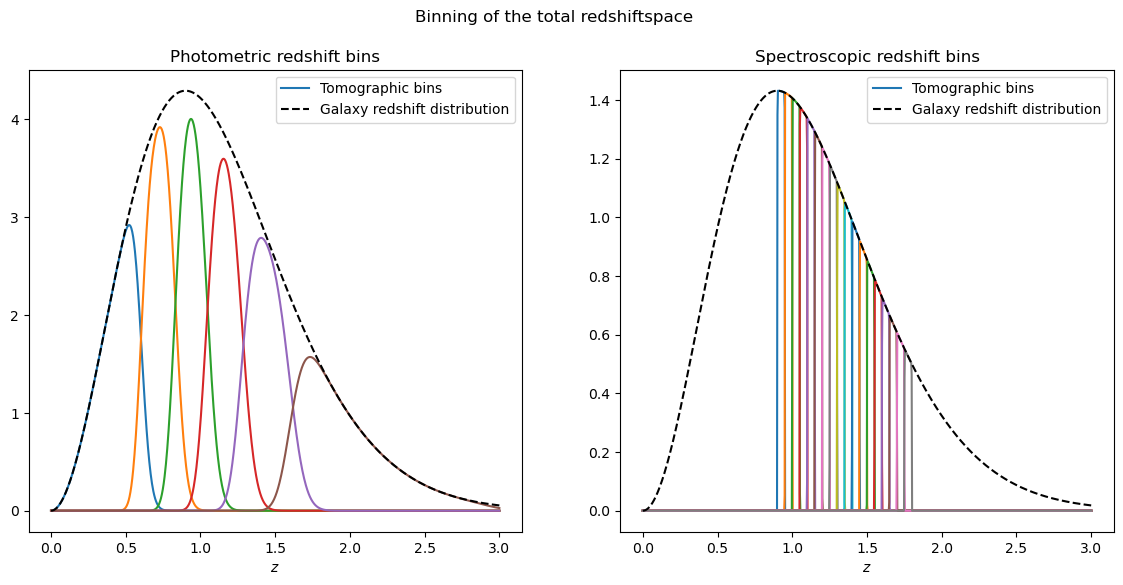

In [3]:
# We define the photometric and spectra through the following:
# From Euclis we find n_bar = 30 per arcmin**2; we want n_bar however to be in steradian
n_bar = 30 * (60**2) * (np.pi/180)**2 # Assume a galaxy density and accompanying reshift distribution:

# Photometric:
n_bar_phot = n_bar/6
dndz = glass.observations.smail_nz(z, z_mode=0.9, alpha=2., beta=1.5)
# dndz *= n_bar
dndz_phot = dndz * n_bar_phot
zbins = glass.observations.equal_dens_zbins(z, dndz_phot, nbins=6)
phot_tomo_bins = glass.observations.tomo_nz_gausserr(z, dndz_phot, 0.03, zbins) # Where the bin error is 0.03

# Spectroscopic:
n_bar_spec = n_bar/18
dndz_spec = dndz * n_bar_spec
spec_z = (np.heaviside((z - 0.9), 1) - np.heaviside((z - 1.8), 1)) * dndz_spec
spec_zbins = glass.observations.fixed_zbins(zmin=0.9, zmax=1.8, dz=0.05)
spec_tomo_bins = glass.observations.tomo_nz_gausserr(z, spec_z, 0.0003, spec_zbins)

# We now visualize the redshift binning:
fig, axes = plt.subplots(figsize=(14, 6), nrows=1, ncols=2)
plt.suptitle("Binning of the total redshiftspace")

# Show the photometric bins in a plot:
axes[0].set_title("Photometric redshift bins")
for i in range(len(phot_tomo_bins)):
    axes[0].plot(z, phot_tomo_bins[i], label="Tomographic bins" if i == 0 else "")
axes[0].plot(z, dndz_phot, 'k--', label='Galaxy redshift distribution')
axes[0].legend()
axes[0].set_xlabel("$z$")

# Show the spectroscopic bins in a plot:
axes[1].set_title("Spectroscopic redshift bins")
for i in range(len(spec_tomo_bins)):
    axes[1].plot(z, spec_tomo_bins[i], label="Tomographic bins" if i == 0 else "")
axes[1].plot(z, dndz_spec, 'k--', label='Galaxy redshift distribution')
axes[1].legend()
axes[1].set_xlabel("$z$")
plt.show()

### Defining the tracers:
Here we define the tracers from which we are building up the angular power spectra. We will need to define these for each of our cosmologies. We will be defining:
- Galaxy clustering (NumberCountsTracer)
    - photometric
    - spectroscopic
    Differentiated by the binning
- Weak lensing (WeakLensingTracer)
    
    Using the photometric bins, since we obderve the source galaxies and their distortions photometrically.
- Cosmic Microwave Background lensing (CMBLensingTracer)
    
    This tracer is based on the CMB surface at a single redshift; z_source=1100, the redshift of last scattering, so we don't ahve to sub-divide the redshift domain

We define the tracer in each of the corresponding bins, such that we build up a dictionary for each of the tracers containing the tracer in each bin.


In [4]:
# LCDM: define the tracers for the vanilla LCDM cosmologocal model:
lcdm_photo_clus_tracer = {i: ccl.NumberCountsTracer(lcdm_cosmo, dndz=(z, phot_tomo_bins[i]), bias=(z, bias), mag_bias=(z, m_bias), has_rsd=True) for i in range(len(phot_tomo_bins))}
lcdm_spec_clus_tracer = {i: ccl.NumberCountsTracer(lcdm_cosmo, dndz=(z, spec_tomo_bins[i]), bias=(z, bias), mag_bias=(z, m_bias), has_rsd=True) for i in range(len(spec_tomo_bins))}
lcdm_wl_tracer = {i: ccl.WeakLensingTracer(lcdm_cosmo, dndz=(z, phot_tomo_bins[i]), has_shear=True) for i in range(len(phot_tomo_bins))}
lcdm_cmb_l_tracer = ccl.CMBLensingTracer(lcdm_cosmo, z_source=1100., n_samples=100)

# 3 massive neutrinos cosmology:
neutrino_photo_clus_tracer = {i: ccl.NumberCountsTracer(neutrino_cosmo, dndz=(z, phot_tomo_bins[i]), bias=(z, bias_neutrino), mag_bias=(z, m_bias), has_rsd=True) for i in range(len(phot_tomo_bins))}
neutrino_spec_clus_tracer = {i: ccl.NumberCountsTracer(neutrino_cosmo, dndz=(z, spec_tomo_bins[i]), bias=(z, bias_neutrino), mag_bias=(z, m_bias), has_rsd=True) for i in range(len(spec_tomo_bins))}
neutrino_wl_tracer = {i: ccl.WeakLensingTracer(neutrino_cosmo, dndz=(z, phot_tomo_bins[i]), has_shear=True) for i in range(len(phot_tomo_bins))}
neutrino_cmb_l_tracer = ccl.CMBLensingTracer(neutrino_cosmo, z_source=1100., n_samples=100)

# Tracers for which the cosmological model has a massless lightest neutrino and 2 equally massive neutrino species:
zero_mm_photo_clus_tracer = {i: ccl.NumberCountsTracer(zero_mm_cosmo, dndz=(z, phot_tomo_bins[i]), bias=(z, bias_zero_mm), mag_bias=(z, m_bias), has_rsd=True) for i in range(len(phot_tomo_bins))}
zero_mm_spec_clus_tracer = {i: ccl.NumberCountsTracer(zero_mm_cosmo, dndz=(z, spec_tomo_bins[i]), bias=(z, bias_zero_mm), mag_bias=(z, m_bias), has_rsd=True) for i in range(len(spec_tomo_bins))}
zero_mm_wl_tracer = {i: ccl.WeakLensingTracer(zero_mm_cosmo, dndz=(z, phot_tomo_bins[i]), has_shear=True) for i in range(len(phot_tomo_bins))}
zero_mm_cmb_l_tracer = ccl.CMBLensingTracer(zero_mm_cosmo, z_source=1100., n_samples=100)

# For a cosmology of 1 massive and 2 massless neutrino species:
single_photo_clus_tracer = {i: ccl.NumberCountsTracer(single_nu_cosmo, dndz=(z, phot_tomo_bins[i]), bias=(z, bias_single_nu), mag_bias=(z, m_bias), has_rsd=True) for i in range(len(phot_tomo_bins))}
single_spec_clus_tracer = {i: ccl.NumberCountsTracer(single_nu_cosmo, dndz=(z, spec_tomo_bins[i]), bias=(z, bias_single_nu), mag_bias=(z, m_bias), has_rsd=True) for i in range(len(spec_tomo_bins))}
single_wl_tracer = {i: ccl.WeakLensingTracer(single_nu_cosmo, dndz=(z, phot_tomo_bins[i]), has_shear=True) for i in range(len(phot_tomo_bins))}
single_cmb_l_tracer = ccl.CMBLensingTracer(single_nu_cosmo, z_source=1100., n_samples=100)

print(lcdm_wl_tracer[0], '\n', neutrino_wl_tracer[0], '\n', zero_mm_wl_tracer[0], '\n', single_wl_tracer[0])

<pyccl.tracers.NzTracer>
	num       kernel             transfer       prefac  bessel 
	 0  0x48965684027e716b         None           2       -1    
 <pyccl.tracers.NzTracer>
	num       kernel             transfer       prefac  bessel 
	 0  0x215c82f5dc6b946d         None           2       -1    
 <pyccl.tracers.NzTracer>
	num       kernel             transfer       prefac  bessel 
	 0  0xba55a6d12c9b9704         None           2       -1    
 <pyccl.tracers.NzTracer>
	num       kernel             transfer       prefac  bessel 
	 0  0x4dc6d4e32cecec8          None           2       -1   


### Angular power spectra of interest
With the tracers we defined above, we can nof set up the angular power spectra we are interested in. Look at the auto and cross corrlations of the CMB lensing tracer. These effectively are the correlations that extend the 6x2pt. analysis to the 10x2pt analysis:
- $\kappa$ x $\kappa $
- $\kappa$ x $\gamma^{\epsilon}$
- $\kappa$ x $\delta_{g}^{p}$
- $\kappa$ x $\delta_{g}^{s}$

#### $\Lambda CDM$ cosmology:
Define the angular power spectra of the auto-correlated and cross-correlated tracers of the $\Lambda CDM$ cosmology:

Note: we evaluate all the angular power spectra in each of the tomorgaphic bins we defined. This gives us: 
- extra layer of cross correlations, if we cross-correlate different bins of drifferent tracers
- the possibility to evaluate each bin over all multipoles(l);
    This is essential because we want to evaluate the angular power spectra on all scales in each of the specific bins that govern our redshift slices.


**Correct the noise types:**
- photometric GC and WL have similar nbar
- Spectroscopic has a different nbar

**Nbar should be in steradian; the dimensionless unit of solid angle. 30 galx arcmin^-2 corresponds to 0.3 gal per bin per arcmin^-2; then multiply by 60^2 for degrees, followed by (pi/180)^2 for steradian**

In [5]:
# Define the auto and cross correlations of the CMB lensing tracer with the tracers of the 6x2pt framework:
lcdm_auto_cmb = {0: ccl.angular_cl(lcdm_cosmo, lcdm_cmb_l_tracer, lcdm_cmb_l_tracer, l, l_limber=1120)}
lcdm_cmb_wl = {i: ccl.angular_cl(lcdm_cosmo, lcdm_cmb_l_tracer, lcdm_wl_tracer[i], l) for i in range(len(phot_tomo_bins))}
lcdm_cmb_gc_ph = {i: ccl.angular_cl(lcdm_cosmo, lcdm_cmb_l_tracer, lcdm_photo_clus_tracer[i], l) for i in range(len(phot_tomo_bins))}
lcdm_cmb_gc_sp = {i: ccl.angular_cl(lcdm_cosmo, lcdm_spec_clus_tracer[i], lcdm_cmb_l_tracer, l) for i in range(len(spec_tomo_bins))}

# For the gaussian covariance, we also need the angular power spectra of the auto-correlations of the tracers:
lcdm_auto_gc_ph = {i: ccl.angular_cl(lcdm_cosmo, lcdm_photo_clus_tracer[i], lcdm_photo_clus_tracer[i], l) for i in range(len(phot_tomo_bins))}
lcdm_auto_gc_sp = {i: ccl.angular_cl(lcdm_cosmo, lcdm_spec_clus_tracer[i], lcdm_spec_clus_tracer[i], l) for i in range(len(spec_tomo_bins))}
lcdm_auto_wl = {i: ccl.angular_cl(lcdm_cosmo, lcdm_wl_tracer[i], lcdm_wl_tracer[i], l) for i in range(len(phot_tomo_bins))}

# The noise types accompanying the angular power spectra:
# Poisson error for galaxy clustering noise, point sources tracing homogeneous background field:
noise_gc = 1/n_bar * np.ones_like(l)
noise_gc_phot = 1/n_bar_phot * np.ones_like(l)
noise_gc_spec = 1/n_bar_spec * np.ones_like(l)

# Combined Poisson and Gaussian error for the point source distributions and Gaussian shear of galaxy shapes:
sigma_e = 0.28 # sigma_e_squared
noise_wl = (sigma_e**2)/n_bar * np.ones_like(l)
noise_wl_corr = (sigma_e**2)/n_bar_phot * np.ones_like(l)

# For the CMB lensing noise we reference the method of Planck, resulting in:
noise_cmb_l = np.loadtxt('/home/xander/Masters-Project/notebooks/cmb_noise_Planck.txt')[:, 1]


As a small sidetrack, we now plot the angular power spectra of auto correlated tracers together with the noise in the corresponding tracer:


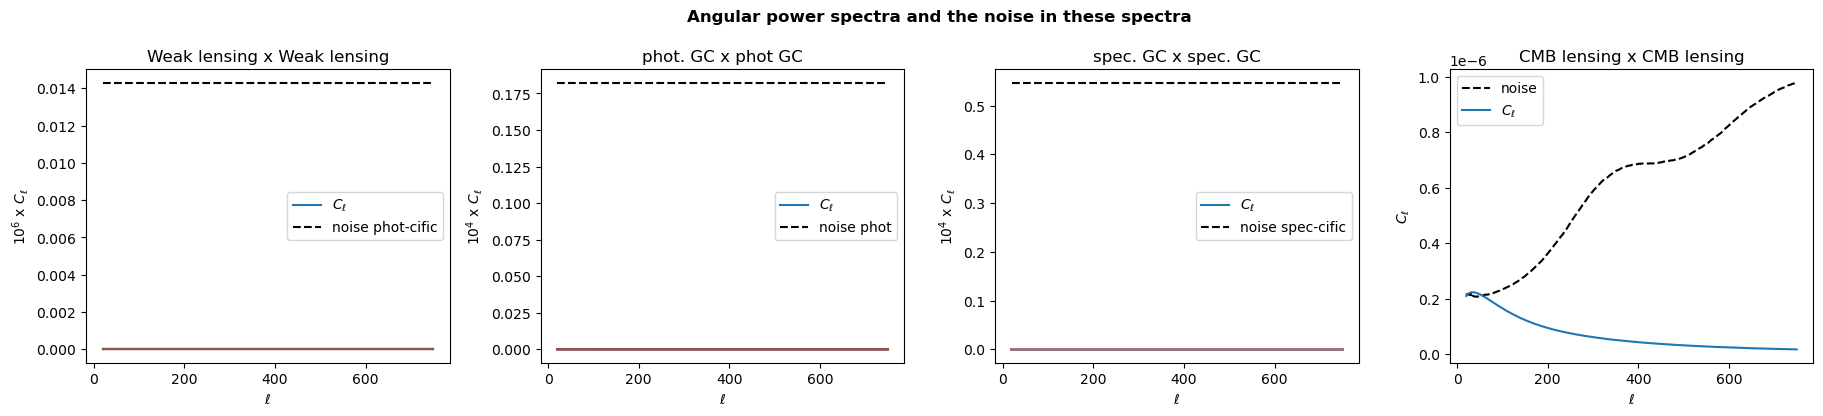

In [6]:
# We check the implementation of the noise by plotting the noise together with the corresponding angular power spectrum:
fig, axes = plt.subplots(figsize=(18, 4), nrows=1, ncols=4)
plt.suptitle("Angular power spectra and the noise in these spectra\n", weight='bold')
plt.tight_layout()
plt.subplots_adjust(wspace=0.25)

# For WL: 
# To include all the tomographic bins:
for j in range(len(phot_tomo_bins)):
    axes[0].plot(l, lcdm_auto_wl[j], label=r'$C_{\ell}$' if j == 0 else "")

# axes[0].plot(l, noise_wl, label='noise')
# axes[0].plot(l, 10e4 * lcdm_auto_wl[5], label=r'$C_{\ell}$')

axes[0].plot(l, noise_wl_corr, 'k--', label='noise phot-cific')
# axes[0].plot(l, 1e6 * lcdm_auto_wl[0], label=r'$C_{\ell}$')
axes[0].set_title("\nWeak lensing x Weak lensing")
axes[0].legend()
axes[0].set_xlabel(r'$\ell$')
axes[0].set_ylabel(r'$10^{6}$ x $C_{\ell}$')

# For Photometric GC:
# To include all the tomographic bins:
for k in range(len(phot_tomo_bins)):
    axes[1].plot(l, lcdm_auto_gc_ph[k], label=r'$C_{\ell}$' if k == 0 else "")

# axes[1].plot(l, noise_gc, label='noise')
# axes[1].plot(l, 10e2 * lcdm_auto_gc_ph[0], label=r'$C_{\ell}$')

axes[1].plot(l, noise_gc_phot, 'k--', label='noise phot')
# axes[1].plot(l, 1e4 * lcdm_auto_gc_ph[0], label=r'$C_{\ell}$')
axes[1].set_title("\nphot. GC x phot GC")
axes[1].legend()
axes[1].set_xlabel(r'$\ell$')
axes[1].set_ylabel(r'$10^{4}$ x $C_{\ell}$')

# For Spectroscopic GC:
# To include all the tomographic bins:
for m in range(len(spec_tomo_bins)):
    axes[2].plot(l, lcdm_auto_gc_sp[m], label=r'$C_{\ell}$' if m == 0 else "")

# axes[2].plot(l, noise_gc, label='noise')
# axes[2].plot(l, 10e2 * lcdm_auto_gc_sp[0], label=r'$C_{\ell}$')

axes[2].plot(l, noise_gc_spec, 'k--', label='noise spec-cific')
#axes[2].plot(l, 1e4 * lcdm_auto_gc_sp[0], label=r'$C_{\ell}$')
axes[2].set_title("\nspec. GC x spec. GC")
axes[2].legend()
axes[2].set_xlabel(r'$\ell$')
axes[2].set_ylabel(r'$10^{4}$ x $C_{\ell}$')

# For CMB lensing:
axes[3].plot(l, noise_cmb_l[0:len(l)], 'k--', label='noise')
axes[3].plot(l, lcdm_auto_cmb[0], label=r'$C_{\ell}$')
axes[3].set_title("\nCMB lensing x CMB lensing")
axes[3].legend()
axes[3].set_xlabel(r'$\ell$')
axes[3].set_ylabel(r'$C_{\ell}$')

plt.show()

#### 3 massive neutrinos according to the NH:
Now we define the similar angular power spectra as we did above but for the 3 different neutrino cosmologies we defined earlier. Note that all neutrino cosmologies have the same total sum of neutrino masses: $\sum_{i} m_{\nu, i} = 0.12 eV$
Similarly to above, we now define the angular power spectra for the auto-correlated and cross-correlated tracers according to the cosmological model in which we have 3 massive neutrinos in a normal mass ordering

In [7]:
# Define the auto and cross correlations of the CMB lensing tracer within the 6xapt framework:
neutrino_auto_cmb = {0: ccl.angular_cl(neutrino_cosmo, neutrino_cmb_l_tracer, neutrino_cmb_l_tracer, l, l_limber=1120)}
neutrino_cmb_wl = {i: ccl.angular_cl(neutrino_cosmo, neutrino_cmb_l_tracer, neutrino_wl_tracer[i], l, l_limber=1120) for i in range(len(phot_tomo_bins))}
neutrino_cmb_gc_ph = {i: ccl.angular_cl(neutrino_cosmo, neutrino_cmb_l_tracer, neutrino_photo_clus_tracer[i], l, l_limber=1120) for i in range(len(phot_tomo_bins))}
neutrino_cmb_gc_sp = {i: ccl.angular_cl(neutrino_cosmo, neutrino_spec_clus_tracer[i], neutrino_cmb_l_tracer, l, l_limber=1120) for i in range(len(spec_tomo_bins))}

# For the gaussian covariance, we also need the auto-correlations of the tracers:
neutrino_auto_gc_ph = {i: ccl.angular_cl(neutrino_cosmo, neutrino_photo_clus_tracer[i], neutrino_photo_clus_tracer[i], l) for i in range(len(phot_tomo_bins))}
neutrino_auto_gc_sp = {i: ccl.angular_cl(neutrino_cosmo, neutrino_spec_clus_tracer[i], neutrino_spec_clus_tracer[i], l) for i in range(len(spec_tomo_bins))}
neutrino_auto_wl = {i: ccl.angular_cl(neutrino_cosmo, neutrino_wl_tracer[i], neutrino_wl_tracer[i], l) for i in range(len(phot_tomo_bins))}

"""
The cross-correlaction within the 6x2pt framework need to be correlated in  a more careful way:
- Note that there are more spectroscopic bins than photometric bins.
- Only 3 photometric bins correspond to the same redshift range as the 18 spectroscopic bins
"""

'\nThe cross-correlaction within the 6x2pt framework need to be correlated in  a more careful way:\n- Note that there are more spectroscopic bins than photometric bins.\n- Only 3 photometric bins correspond to the same redshift range as the 18 spectroscopic bins\n'

#### Massless lightest neutrino; $m_{\nu, 1} = 0$

In [8]:
# Define the auto and cross correlations of the CMB lensing tracer within the 6xapt framework:
zero_mm_auto_cmb = {0: ccl.angular_cl(zero_mm_cosmo, zero_mm_cmb_l_tracer, zero_mm_cmb_l_tracer, l, l_limber=1120)}
zero_mm_cmb_wl = {i: ccl.angular_cl(zero_mm_cosmo, zero_mm_cmb_l_tracer, zero_mm_wl_tracer[i], l, l_limber=1120) for i in range(len(phot_tomo_bins))}
zero_mm_cmb_gc_ph = {i: ccl.angular_cl(zero_mm_cosmo, zero_mm_cmb_l_tracer, zero_mm_photo_clus_tracer[i], l, l_limber=1120) for i in range(len(phot_tomo_bins))}
zero_mm_cmb_gc_sp = {i: ccl.angular_cl(zero_mm_cosmo, zero_mm_spec_clus_tracer[i], zero_mm_cmb_l_tracer, l, l_limber=1120) for i in range(len(spec_tomo_bins))}

# For the gaussian covariance, we also need the auto-correlations of the tracers:
zero_mm_auto_gc_ph = {i: ccl.angular_cl(zero_mm_cosmo, zero_mm_photo_clus_tracer[i], zero_mm_photo_clus_tracer[i], l) for i in range(len(phot_tomo_bins))}
zero_mm_auto_gc_sp = {i: ccl.angular_cl(zero_mm_cosmo, zero_mm_spec_clus_tracer[i], zero_mm_spec_clus_tracer[i], l) for i in range(len(spec_tomo_bins))}
zero_mm_auto_wl = {i: ccl.angular_cl(zero_mm_cosmo, zero_mm_wl_tracer[i], zero_mm_wl_tracer[i], l) for i in range(len(phot_tomo_bins))}

#### One massive neutrino, 2 massless neutrino species

In [9]:
# Define the auto and cross correlations of the CMB lensing tracer within the 6xapt framework:
single_auto_cmb = {0: ccl.angular_cl(single_nu_cosmo, single_cmb_l_tracer, single_cmb_l_tracer, l, l_limber=1120)}
single_cmb_wl = {i: ccl.angular_cl(single_nu_cosmo, single_cmb_l_tracer, single_wl_tracer[i], l, l_limber=1120) for i in range(len(phot_tomo_bins))}
single_cmb_gc_ph = {i: ccl.angular_cl(single_nu_cosmo, single_cmb_l_tracer, single_photo_clus_tracer[i], l, l_limber=1120) for i in range(len(phot_tomo_bins))}
single_cmb_gc_sp = {i: ccl.angular_cl(single_nu_cosmo, single_spec_clus_tracer[i], single_cmb_l_tracer, l, l_limber=1120) for i in range(len(spec_tomo_bins))}

# For the gaussian covariance, we also need the auto-correlations of the tracers:
single_auto_gc_ph = {i: ccl.angular_cl(single_nu_cosmo, single_photo_clus_tracer[i], single_photo_clus_tracer[i], l) for i in range(len(phot_tomo_bins))}
single_auto_gc_sp = {i: ccl.angular_cl(single_nu_cosmo, single_spec_clus_tracer[i], single_spec_clus_tracer[i], l) for i in range(len(spec_tomo_bins))}
single_auto_wl = {i: ccl.angular_cl(single_nu_cosmo, single_wl_tracer[i], single_wl_tracer[i], l) for i in range(len(phot_tomo_bins))}

# Gaussian diagonal covariance

Here we figure out the Gaussian diagonal covariance and try to code this ourselves.
Look at
- Gaussian covariance for the $C_{l}$'s; (Dodelson, example 12.1; section 14.2)
- Different noise types
- Expressions for the different types of probes
- Wick's theorem

*Guess:*
1. Gaussian diagonal covariance describes an striclty auto-correlated parameter space. This is expressed in a diagonal covariance matrix, in which the variance in each parameter is Gaussian. The fact that the covariance matrix is diagonal means that any cross-correlations are disregarded. Thus, the parameters panning parameter space are *univariant* in auto-correlations and invariant in cross-correlations.

Look at sources:
- **[Section 2.5: Johnston, H., Chisari, N. E., Joudaki, S., Reischke, R., Stölzner, B., Loureiro, A., ... & Zhang, Y. H. (2024). 6x2pt: Forecasting gains from joint weak lensing and galaxy clustering analyses with spectroscopic-photometric galaxy cross-correlations. arXiv preprint arXiv:2409.17377](https://arxiv.org/abs/2409.17377)**
- **[Section 6: Rassat, A., Land, K., Lahav, O., & Abdalla, F. B. (2007). Monthly Notices of the Royal Astronomical Society, 377(3), 1085-1094.](https://watermark.silverchair.com/mnras0377-1085.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAA5AwggOMBgkqhkiG9w0BBwagggN9MIIDeQIBADCCA3IGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMwbi2HLzrf3VtF_tBAgEQgIIDQ3YCxz_hwaRlcPM68Treuqkhb3c9-phZGoaHN6CJwoaIHwKG6TezsoaF7pLIpdR4BGIahf0e0uZXQht7x2Vuzb0QYYSj5MJOXPUnFZgk9GUSFKgOT0AiFScn_OZh7rK1i2glwLmMc66YstXfNrAflmxlSYRGEuBfILbYEtxLmicUwPVrmyLi_fJv96QZerxcesviCtEKA3LrI-ZgYlUIHOCrpu88SffoshsenjHBzt9rmJPetf7PrwgMDhL0mEKizmsaILsZgx0j-MWL8rEY9oz3xSCrSzcK6wXVVUfiKz2hfZp9xZkJvpwWIWB5czexmFKiDRIsZ2p4ReT2KvED0kXbK5ocHDyITsVIglihk0inPBTzRJ9mN4jVaNMaMJ_muLbUcMmMCMezaKdTGxWdeMk51g-DmN-t7ts_U-eMg0a5XDenD0CG-FDB9iR4jHK8uRRjZCWeq7W47QodiVoLdPdGd6jI9Clcv3Zc4MvCFs9mJlkWt6Z9I11d0djzMbKrCZf8CgdCU3arMxurJDnomLzQdjWG5deFHJHikFR464Qm0mx7F9jLq_eIqkZtbzaNGlY8_0DdhZ2-eTOkw-Y9v8PlDcjGzjC1GOBKk8uFNpCBOczk2TlITNRftSTFjo3JgF3m-SOTJbiJXWxCsDUGvuwqskCTH01ZaL_MhNtiwE_Sa1wsx9dxx5p0rCQ-aC8xwOzj4XhBzYphkziK-aPEloKsgzrd2GYwDkzaw-aV6l0X_jLIQLzd-ljQVirjuBHGyM30lRXRzoYnTu6227D9VcpVFzw_m816w2rFqC2wl1SP3ySGvndoKzIb1PAzTzlBMTWdJtfvHcjU7E6fdGfFlu6AjjFHz8jki1KT5POLTr-iEqYIcIOjjcSelTPFEybb1tO3UrLpTGHLJNE_osglSDELa7CUvIkbeVLvnuMgHbStuO9vO87U3M61v9z05BwuLPT_pJCGZgPoztHzhsvmv7vsbmr8drrJPMIcPty6EXPhMQqp8CfRQ8dxoDYUwCTjJeKc1147AuT24yXQ7CZ1SAnjem1byWyK7UI2WWTRRQxOdPHWHlQ77kTDcmq7IKNlUiLmmwVUBVtrkIEnlJiRWO3DJMY)**
- **[Later chapters of: Modern Cosmology; S. Dodelson, F. Schmidt](https://books.google.se/books?hl=nl&lr=&id=TpUmEQAAQBAJ&oi=fnd&pg=PP1&dq=modern+cosmology+dodelson&ots=BBo0fsLhcW&sig=KC-2ksaqhpjJvRv05wjpd2nS8Lg&redir_esc=y#v=onepage&q=modern%20cosmology%20dodelson&f=false)**


## Analytical expression:
We can write down the analytical expression for the Gaussian covariance through:
$Z = Cov\left[\hat{C}^{ij}(\ell)\hat{C}^{mn}(\ell')\right]$, with:
$$Cov\left[\hat{C}^{ij}(\ell)\hat{C}^{mn}(\ell')\right] = \frac{\delta_{\ell\ell'}^{K}}{f_{sky} (2\ell + 1)}\left(\hat{C}^{im}(\ell)\hat{C}^{jn}(\ell') + \hat{C}^{in}(\ell)\hat{C}^{jm}(\ell')\right)$$

where $4\pi f_{sky} = A_{survey}$ the fraction of the sky considered in the survey, $\delta_{\ell\ell'}^{K}$ is the K-dimensional Dirac delta which ensures that the multipole moments ($\ell$) are independent. In this expression we must note that $\hat{C}^{ij}(\ell)$ is the observed angular power spectrum. This means that it contains both the signal $\left(S^{ij}(\ell)\right)$ and the noise $\left(N^{ij}\right)$:
$$\hat{C}^{ij}(\ell) = S^{ij}(\ell) + N^{ij}\delta_{ij} $$

More specifically,
$$
\hat{C}^{ij} (\ell) = \begin{cases}
S^{ij} (\ell) + N_{source}^{ij}\delta_{ij}, & \text{if $i \wedge j \in$ source}.\\
S^{ij} (\ell) + N_{lens}^{ij}\delta_{ij}, & \text{if $i \wedge j \in$ lens}.\\
S^{ij} (\ell), & \text{else}
\end{cases}
$$

Where the noise differs for the case of galaxy clustering, weak lensing or CMB lensing. Note also that the noise only occurs for the auto-correlations (e.g. the diagonal of the covariance). 

Note: For CMB lensing, we make use of the noise as defined by Planck, stowed away in the file 'cmb_noise_Planck.txt' which we read in and use when needed.

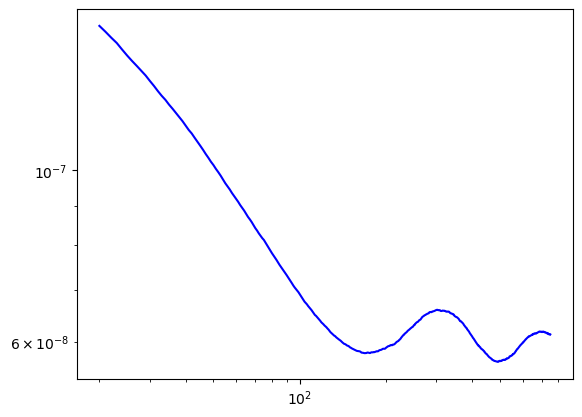

In [10]:
# Start with a simplest case of the diagonal Gaussian covariance:

# The very implest case returns a vector that represents the daigonal of the Gaussian covariance, only consisting of auto-correlated bins
def calc_diag_Gaussian_cov(l, IM, JN, IN, JM, f_sky, noise_a, noise_b=None):
    """
    Note that not all angular power spectra are defined in the same amount of bins. TO account for this, we split the function in 3 different cases:
    The main problem will be the difference between the tracer of CMB lensing being defined in only 1 bin while the other tracers are defined in multiple bins, this we get the 3 cases:

    NOTE: We do not optimize for cross-correlations of the spec GC with other probes than CMB lensing
    """

    # auto CMB lensing x auto CMB lensing, all Cl's defined in 1 bin of length l:
    if len(IM) == len(JN) == len(IN) == len(JM) and len(IM) == len(l):
        pref = 1 / (f_sky * (2 * l + 1))
        ez_diag_cov = pref * (((IM + noise_a) * (JN + noise_a)) + ((IN + noise_a) * (JM + noise_a)))

    # For covariance of auto CMB lensing with cross-correlated CMB lensing Cl, assume:
    elif len(IM) == len(JM) == len(l) and len(JN) == len(IN) < len(l): # Assuming we have less tomorgaphic bins than elements in the array of te multipoles
        ez_diag_cov = {}
        pref = 1 / (f_sky * (2 * l + 1))
        for key in JN.keys():
            ez_diag_cov[key] = pref * (((IM + noise_a) * JN[key]) + ((IN[key]) * (JM + noise_a)))

    # Covariance of two of the same cross-correlated angular power spectra of CMB lensing with any of the other probes, NOTE: let noise_a be the CMB lensing noise, noise_bis the noise of the other probe
    elif len(IM) == len(l) and len(JN) == len(IN) == len(JM) < len(l):
        ez_diag_cov = {}
        pref = 1 / (f_sky * (2 * l + 1))
        for key in JN.keys():
            # for el in JN.keys():
            #     if key == el:
            ez_diag_cov[key] = pref * (((IM + noise_a) * (JN[key] +  noise_b)) + ((IN[key]) * (JM[key])))
                    # ez_diag_cov[key] = pref * (((IM + noise_a) * (JN[el] +  noise_b)) + ((IN[key]) * (JM[el])))

                
    return ez_diag_cov

# Now we want to determine the Gaussian covariance:
# cov_cmbl_wl = simple_Gaussian_cov(l, lcdm_cmb_wl[0], lcdm_cmb_wl[0], lcdm_auto_cmb[0], lcdm_auto_wl[0], 0.00012, noise=noise_wl)
# cov_cmbl_wl_next = simple_Gaussian_cov(l, lcdm_cmb_wl[5], lcdm_cmb_wl[5], lcdm_auto_cmb[5], lcdm_auto_wl[5], 0.00012, noise=noise_wl)

# Determine the relevant auto-correlated angular power spectra
cov_auto_cmb = calc_diag_Gaussian_cov(l, lcdm_auto_cmb[0], lcdm_auto_cmb[0], lcdm_auto_cmb[0], lcdm_auto_cmb[0], 0.36, noise_cmb_l[l], noise_cmb_l[l])

plt.loglog(l, np.sqrt(cov_auto_cmb), label='CMB lensing auto covariance', color='blue')
plt.show()

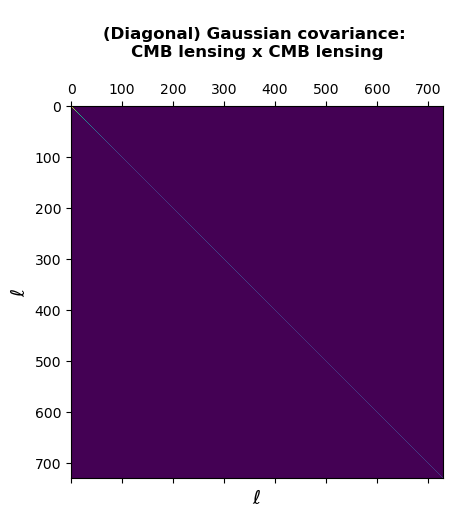

'\n# The other covariances we need:\ncov_cross_cmb_wl = calc_diag_Gaussian_cov(l, lcdm_auto_cmb, lcdm_auto_wl, lcdm_cmb_wl, lcdm_cmb_wl, 0.36, noise_cmb_l[0:len(l)], noise_wl)\ncov_auto_cmb_to_cmb_wl = calc_diag_Gaussian_cov(l, lcdm_auto_cmb, lcdm_cmb_wl, lcdm_cmb_wl, lcdm_auto_cmb, 0.36, noise_cmb_l[0:len(l)])\n\nprint(type(cov_auto_cmb), type(cov_cross_cmb_wl), type(cov_auto_cmb_to_cmb_wl))\n'

In [11]:
# Define a function to plot the covariance as a diagonal matrix:
def plot_array_as_diag_matrix(array, title):
    """
    Function to plot a 1D array as a diagonal matrix
    """
    # First we define an empty matrix, in which we store the values of the covariance in the diagonal:
    diag_matrix = np.zeros([len(array), len(array)])
    for i in range(len(array)):
        for j in range(len(l)):
            if i == j:
                diag_matrix[i, j] = array[i]

    # Now we plot the diagonal matrix:
    plt.matshow(diag_matrix)
    plt.xlabel(r"$\ell$", fontsize=14)
    plt.ylabel(r"$\ell$", fontsize=14)
    plt.title(f"\n{title}\n", weight='bold')
    plt.show()

    return diag_matrix

# Plot the auto-covariance of the CMB lensing:
plot_array_as_diag_matrix(cov_auto_cmb, "(Diagonal) Gaussian covariance: \nCMB lensing x CMB lensing")

"""
# The other covariances we need:
cov_cross_cmb_wl = calc_diag_Gaussian_cov(l, lcdm_auto_cmb, lcdm_auto_wl, lcdm_cmb_wl, lcdm_cmb_wl, 0.36, noise_cmb_l[0:len(l)], noise_wl)
cov_auto_cmb_to_cmb_wl = calc_diag_Gaussian_cov(l, lcdm_auto_cmb, lcdm_cmb_wl, lcdm_cmb_wl, lcdm_auto_cmb, 0.36, noise_cmb_l[0:len(l)])

print(type(cov_auto_cmb), type(cov_cross_cmb_wl), type(cov_auto_cmb_to_cmb_wl))
"""


In [12]:
# Now we define the other diagonal Gaussian covariances based on angular power spectra from the LCDM cosmology:

# First we define the rest of the Gaussian covariances based on the new CMB lensing cross-correlations:
cov_auto_cmb_wl = {i: calc_diag_Gaussian_cov(l, lcdm_auto_cmb[0], lcdm_auto_wl[i], lcdm_cmb_wl[i], lcdm_cmb_wl[i], 0.36, noise_cmb_l[:len(l)], noise_wl_corr) for i in range(len(phot_tomo_bins))}
cov_auto_cmb_gc_sp = {i: calc_diag_Gaussian_cov(l, lcdm_auto_cmb[0], lcdm_auto_gc_sp[i], lcdm_cmb_gc_sp[i], lcdm_cmb_gc_sp[i], 0.36, noise_cmb_l[:len(l)], noise_gc_spec) for i in range(len(spec_tomo_bins))}
cov_auto_cmb_gc_ph = {i: calc_diag_Gaussian_cov(l, lcdm_auto_cmb[0], lcdm_auto_gc_ph[i], lcdm_cmb_gc_ph[i], lcdm_cmb_gc_ph[i], 0.36, noise_cmb_l[:len(l)], noise_gc_phot) for i in range(len(phot_tomo_bins))}


In [13]:
# Next up, we define the Gaussian covariances that contribute to the 6x2pt analysis:
cov_auto_wl = {i: calc_diag_Gaussian_cov(l, lcdm_auto_wl[i], lcdm_auto_wl[i], lcdm_auto_wl[i], lcdm_auto_wl[i], 0.36, noise_wl_corr) for i in range(len(phot_tomo_bins))}
cov_auto_gc_sp = {i: calc_diag_Gaussian_cov(l, lcdm_auto_gc_sp[i], lcdm_auto_gc_sp[i], lcdm_auto_gc_sp[i], lcdm_auto_gc_sp[i], 0.36, noise_gc_spec) for i in range(len(spec_tomo_bins))}
cov_auto_gc_ph = {i: calc_diag_Gaussian_cov(l, lcdm_auto_gc_ph[i], lcdm_auto_gc_ph[i], lcdm_auto_gc_ph[i], lcdm_auto_gc_ph[i], 0.36, noise_gc_phot) for i in range(len(phot_tomo_bins))}

"""
# Now for the cross-correlations we have to be careful about the binning:
cov_auto_gc_sp_cross_ph = {i: calc_diag_Gaussian_cov(l, lcdm_auto_gc_ph[i], lcdm_auto_gc_sp[i], lcdm_cross_gc_sp_ph[i], lcdm_cross_gc_sp_ph[i], noise_gc_phot, noise_gc_spec) for i in range(len(phot_tomo_bins))}
cov_auto_wl_gc_sp = {i: calc_diag_Gaussian_cov(l, lcdm_auto_gc_sp[i], lcdm_auto_wl[i], lcdm_cross_wl_gc_sp[i], lcdm_cross_wl_gc_sp[i], noise_gc_spec, noise_wl_corr) for i in range(len(spec_tomo_bins))}
cov_auto_wl_gc_ph = {i: calc_diag_Gaussian_cov(l, lcdm_auto_gc_ph[i], lcdm_auto_wl[i], lcdm_cross_wl_gc_ph[i], lcdm_cross_wl_gc_ph[i], noise_gc_phot, noise_wl_corr) for i in range(len(phot_tomo_bins))}
"""

'\n# Now for the cross-correlations we have to be careful about the binning:\ncov_auto_gc_sp_cross_ph = {i: calc_diag_Gaussian_cov(l, lcdm_auto_gc_ph[i], lcdm_auto_gc_sp[i], lcdm_cross_gc_sp_ph[i], lcdm_cross_gc_sp_ph[i], noise_gc_phot, noise_gc_spec) for i in range(len(phot_tomo_bins))}\ncov_auto_wl_gc_sp = {i: calc_diag_Gaussian_cov(l, lcdm_auto_gc_sp[i], lcdm_auto_wl[i], lcdm_cross_wl_gc_sp[i], lcdm_cross_wl_gc_sp[i], noise_gc_spec, noise_wl_corr) for i in range(len(spec_tomo_bins))}\ncov_auto_wl_gc_ph = {i: calc_diag_Gaussian_cov(l, lcdm_auto_gc_ph[i], lcdm_auto_wl[i], lcdm_cross_wl_gc_ph[i], lcdm_cross_wl_gc_ph[i], noise_gc_phot, noise_wl_corr) for i in range(len(phot_tomo_bins))}\n'

# Multipoles binning:
Now we bin both the angular power spectra and the Gaussian covariance. As briefly touched upon above, there are two reasons for doing this. The first one is more obvious than the second, namely to reduce the computational cost. The second reason is related to the observations of the LLS. In practice, the mask applied to the observations induces some weak but present correlations between all multipoles. We really observe:
$$C_{l} = \sum_{l^{'}} M_{l, l^{'}} \hat{C_{l^{'}}}$$

with $M_{l, l^{'}}$ the mixing matrix.
This causes the correlations between  multipoles to look like a distorted distribution with a finite peak width. From this distribution we obtain the binwidth $\Delta \ell$ as the full width half mean of the distribution for optimized binning of the multipoles

## Binning the angular power spectra:
This is effectively done by a weigted avarage of the angular power spectra IF the binning is done linearly. For the spectroscopic anguler power spectrum, we want to but the linearly. The sectroscopic angular power spectrum contains some oscillations for multipoles right after the peak in the spectrum. If we would bin this logarithmicaly, we would mis some of the features and losse out on accuracy and information.
For the other anfular power spectra, we can bin logarithmicaly since these spectra are seemingly featureless beyond their large scale shape and thus will not cause any problems when binning logarithmicaly.


In [14]:
# Here we (re)define the binning function to cover both the linear and logarithmic binning:

# Take the number of bins to be 20:
N_l = 20

def bin_multipoles_CL(l, CL, N_l, type="linear"): # For logarithmic binning, take type='log'
    """
    l; array of multipoles
    CL; a dictionary containing arrays of the angular power spectrum in each tomographic bin
        defined off of l such that they are of similar length
    N_l; int; desired number of multipole bins
    type; linear binning is default, change to typ='log' for logarithmic binning
    
    returns:
    l_binned; array of binned multipoles
    binned_Cl; array of the binned agular power spectrum
    dof; int, the number of degreed of freedom
    """

    # Define the empty dictionary in which we can put the binned CL'segment
    binned_Cl = {}

    # Note: Because we would wish to return the dof for each angular powerspectrum including all tomographic bins; such that we must take CL to be the full "tomographic dictionary"
    dof = 0 # The number of degrees of freedom 

    # For linear binning
    if type == "linear":
        # We need the 'N_l + 1' to ensure that we have N_l bins instead of N_l -1 bins following from N_l (data)points
        linear_l = np.linspace(np.min(l), np.max(l), N_l + 1)
        l_binned = 0.5 * (linear_l[:-1] + linear_l[1:])
        
        # Go through all tomographic bins of the angular power spectrum:
        for tomo_bin in range(len(CL)):
            CL_in_bin = []
            for i in range(len(linear_l) - 1):
                current_lin_bin = (l >= linear_l[i]) &  (l < linear_l[i + 1])
                within_bin = CL[tomo_bin][current_lin_bin]
                CL_in_bin.append(np.mean(within_bin))
                # CL_in_bin.append(np.mean(CL[tomo_bin][current_lin_bin]))
                dof += 1
            
            # Store the binned CL's in the empty dictionary defined above: 
            binned_Cl[tomo_bin] = np.array(CL_in_bin)

    # For the case that we want logarithmic binning:
    elif type == "log":
        loglike_l = np.logspace(np.log10(np.min(l[l > 0])), np.log10(np.max(l)), N_l + 1)
        l_binned = np.sqrt(loglike_l[:-1] * loglike_l[1:])

        # For the tomorgaphic bins of the angular power spectrum:
        for tomo_bin in range(len(CL)):
            CL_in_bin = []
            for j in range(len(loglike_l) - 1):
                current_log_bin = (l >= loglike_l[j]) & (l < loglike_l[j + 1])
                CL_in_bin.append( 10**( np.sum( np.log10( CL[tomo_bin][current_log_bin] ) ) / len(current_log_bin[current_log_bin == True]) ) )
                dof += 1
            
            # Store the binned CL's in the empty dictionary defined above:
            binned_Cl[tomo_bin] = np.array(CL_in_bin)


    return l_binned, binned_Cl, dof 


/tmp/ipykernel_2508/2000609827.py:55: RuntimeWarning: invalid value encountered in scalar divide
  CL_in_bin.append( 10**( np.sum( np.log10( CL[tomo_bin][current_log_bin] ) ) / len(current_log_bin[current_log_bin == True]) ) )


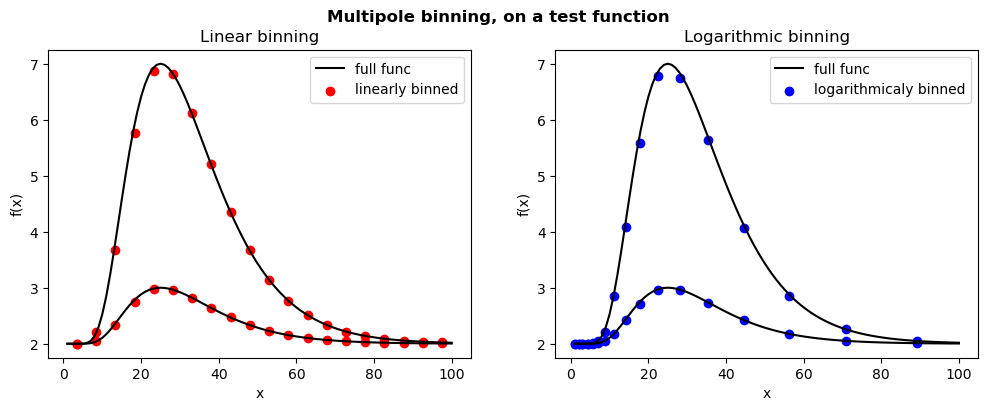

In [15]:
# Test the binning function on a test function: to see the behavior of the binning of the angular power spectra:
x = np.linspace(1, 100, 100)
func = 5 * np.exp((-1 * (x - 25)**2)/(10*x)) + 2
func2 = np.exp((-1 * (x - 25)**2)/(10*x)) + 2

# COmbine test functions in a test dictionary
funcs = {0: func, 1: func2}

# Call the function
lin_func = bin_multipoles_CL(x, funcs, 20)
log_func = bin_multipoles_CL(x, funcs, 20, type="log")

# Plot the results of the binning of the function for logarithmic and linear binning:
fig, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
plt.suptitle("Multipole binning, on a test function\n", weight='bold')

axes[0].plot(x, func, color='k', label='full func')
axes[0].plot(x, func2, color='k')
axes[0].scatter(lin_func[0], lin_func[1][0], color='r', label="linearly binned")
axes[0].scatter(lin_func[0], lin_func[1][1], color='r')
axes[0].legend()
axes[0].set_title("Linear binning")
axes[0].set_xlabel("x")
axes[0].set_ylabel("f(x)")

axes[1].plot(x, func, color='k', label='full func')
axes[1].plot(x, func2, color='k')
axes[1].scatter(log_func[0], log_func[1][0], color='b', label="logarithmicaly binned")
axes[1].scatter(log_func[0], log_func[1][1], color='b')
axes[1].legend()
axes[1].set_title("Logarithmic binning")
axes[1].set_xlabel("x")
axes[1].set_ylabel("f(x)")

plt.show()

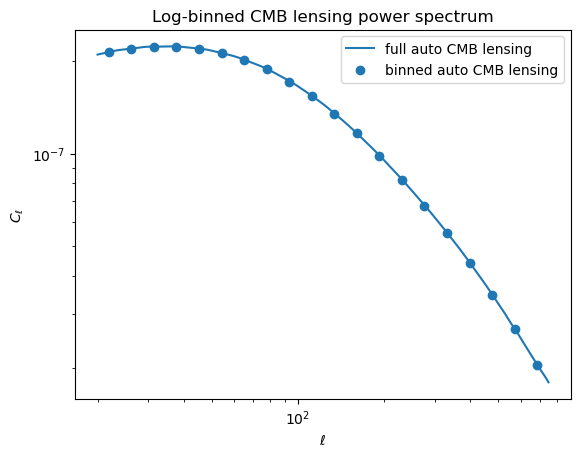

linear l: [ 38.225  74.675 111.125 147.575 184.025 220.475 256.925 293.375 329.825
 366.275 402.725 439.175 475.625 512.075 548.525 584.975 621.425 657.875
 694.325 730.775]
log_lik_l: [ 21.89607597  26.244535    31.4565778   37.7037081   45.19148948
  54.16630948  64.92348705  77.81699015  93.27108311 111.79428717
 133.99611357 160.6071196  192.50294788 230.73313957 276.55566984
 331.47834187 397.30840157 476.2120055  570.78549882 684.14084883]


In [16]:
# Bin the angular power spectra, using the function bin_multipoles_CL defined above:
# First we bin the angular power spectra that correspond to the LCDM cosmology:
log_lik_l, binned_lcdm_auto_cmb, dof_lcdm_auto_cmb = bin_multipoles_CL(l, lcdm_auto_cmb, N_l, type="log")
binned_lcdm_cmb_wl, dof_lcdm_cmb_wl = bin_multipoles_CL(l, lcdm_cmb_wl, N_l, type="log")[1:]
binned_lcdm_cmb_gc_ph, dof_lcdm_cmb_gc_ph = bin_multipoles_CL(l, lcdm_auto_gc_ph, N_l, type="log")[1:]
linear_l, binned_lcdm_cmb_gc_sp, dof_lcdm_cmb_gc_sp = bin_multipoles_CL(l, lcdm_auto_gc_sp, N_l)

binned_lcdm_auto_gc_ph, dof_lcdm_auto_gc_ph = bin_multipoles_CL(l, lcdm_auto_gc_ph, N_l, type="log")[1:]
binned_lcdm_auto_gc_sp, dof_lcdm_auto_gc_sp = bin_multipoles_CL(l, lcdm_auto_gc_sp, N_l)[1:]
binned_lcdm_auto_wl, dof_lcdm_auto_wl = bin_multipoles_CL(l, lcdm_auto_wl, N_l, type="log")[1:]

plt.figure()
plt.title("Log-binned CMB lensing power spectrum")
plt.loglog(l, lcdm_auto_cmb[0], label='full auto CMB lensing')
plt.scatter(log_lik_l, binned_lcdm_auto_cmb[0], label='binned auto CMB lensing')
# plt.plot(l, 1e-3 * lcdm_auto_gc_sp[0], color='r', label='1st bin auto spec GC')
# plt.scatter(linear_l, 1e-3 * binned_lcdm_auto_gc_sp[0], color='r', label='binned auto spec GC')
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_{\ell}$")
plt.legend()
plt.show()

print("linear l:", linear_l)
print("log_lik_l:", log_lik_l)

### Multipole binning for the different neutrino cosmologies:
We will now bin all the angular power spectra corresponding to the three different neutrino cosmologies that we defined above:
- A cosmology with 3 massive neutrinos
- A massless lightest neutrino, with 2 equally massive neutrinos
- A cosmology with 2 massless meutrinos and 1 (massive) massive neutrino

We will perform the multipole binning in this order in 3 separate cells below:

In [17]:
# We start with the cosmological model of 3 massive neutrinos in the Normal mass ordering (or normal hierarchy(NH)):
binned_neutrino_auto_cmb, dof_neutrino_auto_cmb = bin_multipoles_CL(l, neutrino_auto_cmb, N_l, type='log')[1:]
binned_neutrino_cmb_wl, dof_neutrino_cmb_wl = bin_multipoles_CL(l, neutrino_cmb_wl, N_l, type='log')[1:]
binned_neutrino_cmb_gc_ph, dof_neutrino_cmb_gc_ph = bin_multipoles_CL(l, neutrino_cmb_gc_ph, N_l, type='log')[1:]
binned_neutrino_cmb_gc_sp, dof_neutrino_cmb_gc_sp = bin_multipoles_CL(l, neutrino_cmb_gc_sp, N_l)[1:]

binned_neutrino_auto_gc_ph, dof_neutrino_auto_gc_ph = bin_multipoles_CL(l, neutrino_auto_gc_ph, N_l, type='log')[1:]
binned_neutrino_auto_gc_sp, dof_neutrino_auto_gc_sp = bin_multipoles_CL(l, neutrino_auto_gc_sp, N_l)[1:]
binned_neutrino_auto_wl, dof_neutrino_auto_wl = bin_multipoles_CL(l, neutrino_auto_wl, N_l, type='log')[1:]

print(binned_neutrino_auto_cmb)

{0: array([2.10082504e-07, 2.14769841e-07, 2.17735484e-07, 2.17325782e-07,
       2.13486023e-07, 2.06138821e-07, 1.95379437e-07, 1.81792179e-07,
       1.65706710e-07, 1.48058580e-07, 1.29830054e-07, 1.11666157e-07,
       9.44242958e-08, 7.86345928e-08, 6.47429050e-08, 5.26488409e-08,
       4.20637769e-08, 3.30073573e-08, 2.54474967e-08, 1.94418849e-08])}


In [18]:
# Now we look at the cosmological model in which we consider the lightest neutrino to be massless:
binned_zero_mm_auto_cmb, dof_zero_mm_auto_cmb = bin_multipoles_CL(l, zero_mm_auto_cmb, N_l, type='log')[1:]
binned_zero_mm_cmb_wl, dof_zero_mm_cmb_wl = bin_multipoles_CL(l, zero_mm_cmb_wl, N_l, type='log')[1:]
binned_zero_mm_cmb_gc_ph, dof_zero_mm_cmb_gc_ph = bin_multipoles_CL(l, zero_mm_cmb_gc_ph, N_l, type='log')[1:]
binned_zero_mm_cmb_gc_sp, dof_zero_mm_cmb_gc_sp = bin_multipoles_CL(l, zero_mm_cmb_gc_sp, N_l)[1:]

binned_zero_mm_auto_gc_ph, dof_zero_mm_auto_gc_ph = bin_multipoles_CL(l, zero_mm_auto_gc_ph, N_l, type='log')[1:]
binned_zero_mm_auto_gc_sp, dof_zero_mm_auto_gc_sp = bin_multipoles_CL(l, zero_mm_auto_gc_sp, N_l)[1:]
binned_zero_mm_auto_wl, dof_zero_mm_auto_wl = bin_multipoles_CL(l, zero_mm_auto_wl, N_l, type='log')[1:]

In [19]:
# Lastly we perform the binning for the cosmological model in which we only consider the presence of ine massive neutrino, next to two massless neutrinos
binned_single_auto_cmb, dof_single_auto_cmb = bin_multipoles_CL(l, single_auto_cmb, N_l, type='log')[1:]
binned_single_cmb_wl, dof_single_cmb_wl = bin_multipoles_CL(l, single_cmb_wl, N_l, type='log')[1:]
binned_single_cmb_gc_ph, dof_single_cmb_gc_ph = bin_multipoles_CL(l, single_cmb_gc_ph, N_l, type='log')[1:]
binned_single_cmb_gc_sp, dof_single_cmb_gc_sp = bin_multipoles_CL(l, single_cmb_gc_sp, N_l)[1:]

binned_single_auto_gc_ph, dof_single_auto_gc_ph = bin_multipoles_CL(l, single_auto_gc_ph, N_l, type='log')[1:]
binned_single_auto_gc_sp, dof_single_auto_gc_sp = bin_multipoles_CL(l, single_auto_gc_sp, N_l)[1:]
binned_single_auto_wl, dof_single_auto_wl = bin_multipoles_CL(l, single_auto_wl, N_l, type='log')[1:]

## Binning the Gaussian covariance:
The binning of the Gaussian covariance is different than the angular power spectra:


In [20]:
def bin_cov_dict(
    ell,
    cov_dict,
    n_ell_bins=20,
    type='linear',
    fsky=0.36,
    remove_prefactor=True
):
    """
    Bin a dictionary of diagonal Gaussian covariances over ell,
    optionally removing the (2ℓ+1)/fsky prefactor if present.

    Parameters
    ----------
    cov_dict : dict
        Dictionary of diagonal Gaussian covariances (variances per ell),
        keyed by tomographic bin (or other index).
    ell : array_like
        Multipole array (same length as each covariance array).
    n_ell_bins : int
        Number of ell bins.
    linear_binning : bool
        Whether to use linear binning (otherwise uses log).
    fsky : float
        Sky fraction used in covariance prefactor.
    remove_prefactor : bool
        If True, divide out the (2ℓ+1)/fsky factor before binning.

    Returns
    -------
    binned_cov : dict
        Dictionary of binned variances of the mean per bin.
    bin_centers : array
        Centers of ell bins (arithmetic or geometric mean).
    counts : dict
        Number of ℓ values per bin for each key.
    """
    ell = np.asarray(ell)
    two_ell_plus_one = 2 * (ell + 1)
    #prefactor = (two_ell_plus_one * fsky)

    if type == 'linear':
        bin_edges = np.linspace(ell.min(), ell.max(), n_ell_bins + 1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    elif type == 'log':
        bin_edges = np.logspace(np.log10(ell[ell > 0].min()), np.log10(ell.max()), n_ell_bins + 1)
        bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])

    binned_cov = {}
    counts = {}

    for key, cov in cov_dict.items():
        cov = np.asarray(cov)
        if remove_prefactor:
            cov_noprefactor = cov * (fsky*two_ell_plus_one)
        else:
            cov_noprefactor = np.asarray(cov)

        binned = []
        bin_counts = []

        for i in range(n_ell_bins):
            mask = (ell >= bin_edges[i]) & (ell < bin_edges[i + 1])
            N = np.sum(mask)
            bin_counts.append(N)

            if N == 0:
                binned.append(np.nan)
            else:
                weighted_sum = np.sum(cov_noprefactor[mask] / two_ell_plus_one[mask])
                binned_covariance = weighted_sum / (fsky * N * N)
                binned.append(binned_covariance)

        binned_cov[key] = np.array(binned)
        counts[key] = np.array(bin_counts)

    return binned_cov, bin_centers, counts

In [21]:
# Bin the Gaussian covariances determined from the angular power spectra of the LCDM cosmology: 
binned_cov_auto_cmb, log_bins, dof_cov_auto_cmb = bin_cov_dict(l, {0: cov_auto_cmb}, N_l, type='log') 
binned_cov_auto_cmb_wl, dof_cov_auto_cmb_wl = bin_cov_dict(l, cov_auto_cmb_wl, N_l, type='log')[::2]
binned_cov_auto_cmb_gc_ph, dof_cov_auto_cmb_gc_ph = bin_cov_dict(l, cov_auto_cmb_gc_ph, N_l, type='log')[::2]
binned_cov_auto_cmb_gc_sp, lin_bins, dof_cov_auto_cmb_gc_sp = bin_cov_dict(l, cov_auto_cmb_gc_sp, N_l, type='linear')

binned_cov_auto_wl, dof_cov_auto_wl = bin_cov_dict(l, cov_auto_wl, N_l, type='log')[::2]
binned_cov_auto_gc_ph, dof_cov_auto_gc_ph = bin_cov_dict(l, cov_auto_gc_ph, N_l, type='log')[::2]
binned_cov_auto_gc_sp, dof_cov_auto_gc_sp = bin_cov_dict(l, cov_auto_gc_sp, N_l, type='linear')[::2]

# Need to figure out the use of 'counts':
# print((binned_cov_auto_cmb), len(dof_cov_auto_gc_ph[0]), np.sum(dof_cov_auto_cmb_gc_sp[0]))
print(binned_neutrino_auto_cmb)

{0: array([2.10082504e-07, 2.14769841e-07, 2.17735484e-07, 2.17325782e-07,
       2.13486023e-07, 2.06138821e-07, 1.95379437e-07, 1.81792179e-07,
       1.65706710e-07, 1.48058580e-07, 1.29830054e-07, 1.11666157e-07,
       9.44242958e-08, 7.86345928e-08, 6.47429050e-08, 5.26488409e-08,
       4.20637769e-08, 3.30073573e-08, 2.54474967e-08, 1.94418849e-08])}


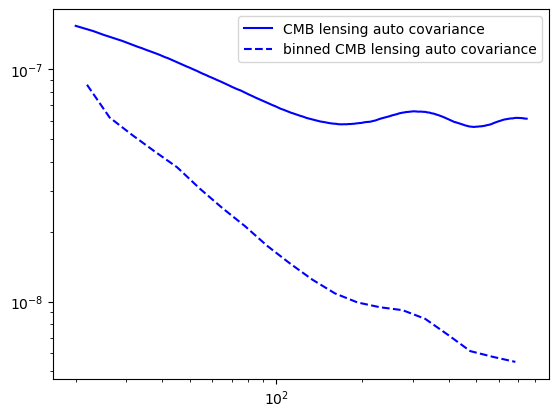

In [22]:
plt.loglog(l, np.sqrt(cov_auto_cmb), label='CMB lensing auto covariance', color='blue')
plt.loglog(log_bins, np.sqrt(binned_cov_auto_cmb[0]), label='binned CMB lensing auto covariance', color='blue', linestyle='--')
plt.legend()
plt.show()

Let us now perform the multipole binning for both the angular power spectra and the gaussian covariance

# $\Delta \chi^{2}$
Now we can determine the value of $\Delta \chi ^{2}$ in each bin; to do so we calculate the following:$$\Delta \chi ^{2} \sim \left(C_{l}^{1} - C_{l}^{2}\right)^{T} Cov^{-1}\left[C_{l}^{1}\right]\left(C_{l}^{1} - C_{l}^{2}\right)$$

in which $C_{l}^{1}$ would be corresponding to a cosmology of massless neutrinos and $C_{l}^{2}$ corresponds to the hypothetical cosmology containing a number of massive neutrinos. Note: We define the Gaussian covariance using the angular power spectra of the $\Lambda CDM$ cosmologies and use these to find the quantity of $\Delta \chi^{2}$

This is a result of: $$\Delta \chi ^{2} = \chi_{1}^{2} - \chi_{2}^{2}$$
with 
$$ \chi_{i}^{2} \sim \left(C_{l}^{i}\right)^{T} Cov^{-1}\left[C_{l}^{i}\right]\left(C_{l}^{i}\right)$$

**Incorporate the degrees of freedom accordingly and use the result in the get_p_value function**


In [23]:
# Look at the 
def calc_del_chi_squared(Cl_lcdm, Cl_neutrino, cov, N_l=N_l):

    """
    Function to calculate the Delta chi squared between LCDM and a specific neutrino cosmology.
    Cl_1: array or dict; containing the LCDM spectra  
    Cl_2: array or dict; containing the neutrino spectra

    cov: array or dict; the diagonal Gaussian covariance matrix based on the LCDM cosmology

    Returns:
    del_chi: float; the Delta chi squared value between Cl_1 and Cl_2, given the covariance matrix
    """
    
    del_chi = 0

    if len(Cl_lcdm) == len(Cl_neutrino) == len(cov) and len(Cl_lcdm) == N_l:
        diff = Cl_lcdm - Cl_neutrino
        print("absolute difference", np.abs(diff))
        
        for k in range(len(cov)):
            product_k = (1 / cov) * diff
            print(f"product-k -- {product_k}")

            del_chi += diff[k] * product_k[k]

    # # Depending on the angular power spectra, we must consider the covariance to be a dictionary of arrays or an array:
    else:
        # Define the array in which we store the Delta chi squared for each bin:
        for key in Cl_lcdm.keys():

            # Determine the Cl_1 - Cl_2 in the current bin we loop within:
            diff_i = Cl_lcdm[key] - Cl_neutrino[key]
            print("absolute difference", np.abs(diff_i))

            product_i = (1/cov[key]) * diff_i
            print(f"product-i -- {product_i}")

            for j in range(len(cov[key])):

                # To determine the value of Delta chi squared, we perform a dot-product between the transposed difference and the product of the inverse of the
                # diagonal of the Gaussian covariance and the difference itself. NOTE: since we consider the simple case of a diagonal Gaussian covariance, we
                # can take 1/Cov as the inverse:
                del_chi += (diff_i[j] * product_i[j])
        
    # # For the case of CMB lensing auto correlated power spectra
    # else:
    #     diff = Cl_lcdm - Cl_neutrino
    #     for k in range(len(cov)):
    #         product_k = (1 / cov) * diff
    #         del_chi += diff[k] * product_k[k]
    
    return del_chi

del_chi_auto_cmb_neutrino = calc_del_chi_squared(binned_lcdm_auto_cmb, binned_neutrino_auto_cmb, binned_cov_auto_cmb)

print(del_chi_auto_cmb_neutrino)

# plt.matshow(del_chi_auto_cmb_neutrinos)
# plt.xlabel(r"$\ell$", fontsize=14)
# plt.ylabel(r"$\ell$", fontsize=14)
# # plt.xticks([0, 1, 2, 3, 4, 5], ["bin 1", "bin 2", "bin 3", "bin 4", "bin 5", "bin 6"])
# # plt.yticks([0, 1, 2, 3, 4, 5], ["bin 1", "bin 2", "bin 3", "bin 4", "bin 5", "bin 6"])
# plt.title("\n" + r"$\Delta \chi^{2}$ for $C_{\ell}^{\kappa\kappa}$: $\Lambda CDM$ vs 3 massive $m_{\nu}$ in NH" + "\n", weight='bold')
# plt.show()


absolute difference [4.52966221e-09 5.00179529e-09 5.51040024e-09 5.95410663e-09
 6.26457764e-09 6.45032167e-09 6.49813194e-09 6.38816683e-09
 6.12040140e-09 5.71696392e-09 5.22048617e-09 4.64872793e-09
 4.05438186e-09 3.46466218e-09 2.92201813e-09 2.42695676e-09
 1.98651122e-09 1.58875821e-09 1.24991140e-09 9.67508935e-10]
product-i -- [  614649.97234029  1297223.91052236  2021792.59820078  3029727.07104146
  4371880.39910238  6855622.75633954 10156649.75780135 14275988.90121123
 20322561.53584151 26809761.7956119  33825937.40533979 39530451.3644176
 41257306.80379781 38778794.16624907 34651045.73096295 34173019.70368186
 38280864.96158556 42420263.90022605 37388201.43195149 31984609.33962408]
1.6121992086658354


## For each cosmology: $\Delta \chi^{2}$

Similar to the multipole binning, we go through each of the cosmological models. We use the covariances we determined based on the $\Lambda CDM$ cosmology.

(## Extend the results
There are two approaches in which we can extend these results. First of all, to keep it simple and straigtforward, we can extend the result by using the same definition of the daigonal Gaussian covariance and correlate other probes to build up the full covariance matrix consisting of diagonal suubmatrices that only auto-correlate the bins. Alternatively we can rewrite the definition of the Gaussian covariance with the goal of generalizing the covariance matrix by including cross-correlated bins.)

In [24]:
# Now we determine the del chi squared for the other models:

# We start with the cosmology of 3 massive neutrinos in the normal mass ordering:
del_chi_cmb_wl_neutrino = calc_del_chi_squared(binned_lcdm_cmb_wl, binned_neutrino_cmb_wl, binned_cov_auto_cmb_wl)
del_chi_cmb_gc_ph_neutrino = calc_del_chi_squared(binned_lcdm_cmb_gc_ph, binned_neutrino_cmb_gc_ph, binned_cov_auto_cmb_gc_ph)
del_chi_cmb_gc_sp_neutrino = calc_del_chi_squared(binned_lcdm_cmb_gc_sp, binned_neutrino_cmb_gc_sp, binned_cov_auto_cmb_gc_sp)

del_chi_auto_wl_neutrino = calc_del_chi_squared(binned_lcdm_auto_wl, binned_neutrino_auto_wl, binned_cov_auto_wl)
del_chi_auto_gc_ph_neutrino = calc_del_chi_squared(binned_lcdm_auto_gc_ph, binned_neutrino_auto_gc_ph, binned_cov_auto_gc_ph)
del_chi_auto_gc_sp_neutrino = calc_del_chi_squared(binned_lcdm_auto_gc_sp, binned_neutrino_auto_gc_sp, binned_cov_auto_gc_sp)

absolute difference [4.26506121e-10 4.13633776e-10 3.80784263e-10 3.51927899e-10
 2.97936215e-10 2.64982955e-10 2.26294478e-10 1.80447023e-10
 1.52412277e-10 1.23952252e-10 9.90009285e-11 8.42024337e-11
 6.81990925e-11 5.74667300e-11 4.74896797e-11 4.05556952e-11
 3.38533752e-11 2.84374800e-11 2.36841239e-11 1.94525870e-11]
product-i -- [ 135945.21870892  261628.19838854  348640.94106394  482105.06652712
  566921.44206648  752277.20628973  918014.11572547 1010688.86826083
 1188169.34550135 1271686.20402487 1300388.75485819 1329024.30518195
 1180963.25176529  987282.11578312  767347.3281845   686888.05330253
  723593.95488586  839953.58202195  792807.7410304   689012.00537142]
absolute difference [9.41761570e-10 9.21205694e-10 8.75204340e-10 8.18299263e-10
 7.16688926e-10 6.28412472e-10 5.38588287e-10 4.50752614e-10
 3.83945684e-10 3.09367682e-10 2.41812122e-10 1.98847153e-10
 1.60509291e-10 1.30593042e-10 1.06882993e-10 8.83760549e-11
 7.35774544e-11 6.18256296e-11 5.18678657e-11 4.351

In [25]:
# Two massless neutrinos and a massless lightests neutrino:
del_chi_auto_cmb_zero_mm = calc_del_chi_squared(binned_lcdm_auto_cmb, binned_zero_mm_auto_cmb, binned_cov_auto_cmb)
del_chi_cmb_wl_zero_mm = calc_del_chi_squared(binned_lcdm_cmb_wl, binned_zero_mm_cmb_wl, binned_cov_auto_cmb_wl)
del_chi_cmb_gc_ph_zero_mm = calc_del_chi_squared(binned_lcdm_cmb_gc_ph, binned_zero_mm_cmb_gc_ph, binned_cov_auto_cmb_gc_ph)
del_chi_cmb_gc_sp_zero_mm = calc_del_chi_squared(binned_lcdm_cmb_gc_sp, binned_zero_mm_cmb_gc_sp, binned_cov_auto_cmb_gc_sp)

del_chi_auto_wl_zero_mm = calc_del_chi_squared(binned_lcdm_auto_wl, binned_zero_mm_auto_wl, binned_cov_auto_wl)
del_chi_auto_gc_ph_zero_mm = calc_del_chi_squared(binned_lcdm_auto_gc_ph, binned_zero_mm_auto_gc_ph, binned_cov_auto_gc_ph)
del_chi_auto_gc_sp_zero_mm = calc_del_chi_squared(binned_lcdm_auto_gc_sp, binned_zero_mm_auto_gc_sp, binned_cov_auto_gc_sp)

absolute difference [4.20804872e-09 4.69498346e-09 5.23274343e-09 5.71800991e-09
 6.07865672e-09 6.32292478e-09 6.43349814e-09 6.38427045e-09
 6.17108354e-09 5.81354119e-09 5.35034122e-09 4.80023496e-09
 4.21424398e-09 3.62334183e-09 3.07023728e-09 2.56057719e-09
 2.10105492e-09 1.68515048e-09 1.32745936e-09 1.03092431e-09]
product-i -- [  571008.81102154  1217651.75124212  1919918.96788302  2909590.04893262
  4242131.18062898  6720220.97855654 10055626.44906568 14267281.42993106
 20490849.65930594 27262661.90678352 34667328.21135644 40818791.22354777
 42884060.40327206 40554841.9692018  36408717.47535925 36054476.28133168
 40488167.83429594 44993962.72710793 39707868.90876155 34081040.61736002]
absolute difference [4.43552157e-10 4.33958829e-10 4.02913671e-10 3.74376251e-10
 3.19361426e-10 2.84650796e-10 2.43628173e-10 1.95342242e-10
 1.64931310e-10 1.34400220e-10 1.07743146e-10 9.14184109e-11
 7.41482143e-11 6.23527632e-11 5.15206152e-11 4.38835272e-11
 3.65901566e-11 3.06839515e-11 

In [26]:
# Lastly we consider the model that features only one massive neutrino:
del_chi_auto_cmb_single = calc_del_chi_squared(binned_lcdm_auto_cmb, binned_single_auto_cmb, binned_cov_auto_cmb)
del_chi_cmb_wl_single = calc_del_chi_squared(binned_lcdm_cmb_wl, binned_single_cmb_wl, binned_cov_auto_cmb_wl)
del_chi_cmb_gc_ph_single = calc_del_chi_squared(binned_lcdm_cmb_gc_ph, binned_single_cmb_gc_ph, binned_cov_auto_cmb_gc_ph)
del_chi_cmb_gc_sp_single = calc_del_chi_squared(binned_lcdm_cmb_gc_sp, binned_single_cmb_gc_sp, binned_cov_auto_cmb_gc_sp)

del_chi_auto_wl_single = calc_del_chi_squared(binned_lcdm_auto_wl, binned_single_auto_wl, binned_cov_auto_wl)
del_chi_auto_gc_ph_single = calc_del_chi_squared(binned_lcdm_auto_gc_ph, binned_single_auto_gc_ph, binned_cov_auto_gc_ph)
del_chi_auto_gc_sp_single = calc_del_chi_squared(binned_lcdm_auto_gc_sp, binned_single_auto_gc_sp, binned_cov_auto_gc_sp)

absolute difference [3.23627318e-09 3.69531997e-09 4.22888244e-09 4.74150773e-09
 5.16007144e-09 5.49223064e-09 5.71805961e-09 5.80068699e-09
 5.72808917e-09 5.50612079e-09 5.16984050e-09 4.72384593e-09
 4.22270253e-09 3.68813654e-09 3.17191940e-09 2.67886458e-09
 2.22356160e-09 1.80014622e-09 1.43398936e-09 1.12250315e-09]
product-i -- [  439144.27415216   958387.36639781  1551597.49663434  2412700.21004323
  3601075.20273748  5837330.80102803  8937388.35794069 12963115.28228017
 19019903.59274859 25821010.74382141 33497780.81393572 40169217.19012788
 42970134.45513518 41280067.33670996 37614525.0846189  37720034.25357664
 42848920.58448297 48064379.56799683 42894466.98882676 37108520.2119673 ]
absolute difference [4.14074874e-10 4.18643483e-10 4.01209423e-10 3.81670113e-10
 3.32582803e-10 3.00840145e-10 2.60963987e-10 2.12299180e-10
 1.80774091e-10 1.48592625e-10 1.20056270e-10 1.01859770e-10
 8.29211923e-11 6.95411587e-11 5.74469583e-11 4.87430653e-11
 4.05911111e-11 3.39698732e-11 

# P-value
To be able to (loosly) identify the effect of the neutrino masses on the angular power spectra, we determine the p-value based on the $\Delta \chi^{2}$ acquired before.

We start by determining the value chi squared from $\Delta \chi^{2}$ and the number of degrees of freedom.
This we can pass on into the calculation of the p-value.

- **Use scipy to calc chi squared;  
for cdf -- del chi 2 - dof**
- **depending on the use of pdf or cdf in the previous step, determine the p-value;   
For the cdf it should be 1 - chi2**

**[p-value, read and write](https://en.wikipedia.org/wiki/P-value#)**

**[some reference on the p-value](https://matthew-brett.github.io/teaching/on_cdfs.html)**

**[scipy, chisquared from cdf](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html)**

In [27]:
def get_p_value(value_chi2, dof):
    """
    Function to determine the p-value of the chi squared distribution
    """
    
    p = 1 - chi2.cdf(value_chi2, dof)

    print(f"Chi squared value: {value_chi2}, with {dof} degrees of freedom, gives a p-value of: {p:.4f}")
    
    return p

Now all that is left is to determine the p-values for each of the calculations and present the tables

In [28]:
# Last step of the identifiability test:

# [m1, m2, m3], in normal mass ordering:
p_auto_cmb_neutrino = get_p_value(del_chi_auto_cmb_neutrino, dof_neutrino_auto_cmb)
p_cmb_wl_neutrino = get_p_value(del_chi_cmb_wl_neutrino, dof_neutrino_cmb_wl)
p_cmb_gc_ph_neutrino = get_p_value(del_chi_cmb_gc_ph_neutrino, dof_neutrino_cmb_gc_ph)
p_cmb_gc_sp_neutrino = get_p_value(del_chi_cmb_gc_sp_neutrino, dof_neutrino_cmb_gc_sp)

p_auto_wl_neutrino = get_p_value(del_chi_auto_wl_neutrino, dof_neutrino_auto_wl)
p_auto_gc_ph_neutrino = get_p_value(del_chi_auto_gc_ph_neutrino, dof_neutrino_auto_gc_ph)
p_auto_gc_sp_neutrino = get_p_value(del_chi_auto_gc_sp_neutrino, dof_neutrino_auto_gc_sp)

Chi squared value: 1.6121992086658354, with 20 degrees of freedom, gives a p-value of: 1.0000
Chi squared value: 0.31729773812585144, with 120 degrees of freedom, gives a p-value of: 1.0000
Chi squared value: 2884226.680753677, with 120 degrees of freedom, gives a p-value of: 0.0000
Chi squared value: 43757804.59751612, with 360 degrees of freedom, gives a p-value of: 0.0000


Chi squared value: 6.131709064829649e-11, with 120 degrees of freedom, gives a p-value of: 1.0000
Chi squared value: 5.170798700184459e-07, with 120 degrees of freedom, gives a p-value of: 1.0000
Chi squared value: 1.3578817948547464e-06, with 360 degrees of freedom, gives a p-value of: 1.0000


In [29]:
# [0, m, m]:
p_auto_cmb_zero_mm = get_p_value(del_chi_auto_cmb_zero_mm, dof_zero_mm_auto_cmb)
p_cmb_wl_zero_mm = get_p_value(del_chi_cmb_wl_zero_mm, dof_zero_mm_cmb_wl)
p_cmb_gc_ph_zero_mm = get_p_value(del_chi_cmb_gc_ph_zero_mm, dof_zero_mm_cmb_gc_ph)
p_cmb_gc_sp_zero_mm = get_p_value(del_chi_cmb_gc_sp_zero_mm, dof_zero_mm_cmb_gc_sp)

p_auto_wl_zero_mm = get_p_value(del_chi_auto_wl_zero_mm, dof_zero_mm_auto_wl)
p_auto_gc_ph_zero_mm = get_p_value(del_chi_auto_gc_ph_zero_mm, dof_zero_mm_auto_gc_ph)
p_auto_gc_sp_zero_mm = get_p_value(del_chi_auto_gc_sp_zero_mm, dof_zero_mm_auto_gc_sp)

Chi squared value: 1.7057319581833936, with 20 degrees of freedom, gives a p-value of: 1.0000
Chi squared value: 0.34848342743657496, with 120 degrees of freedom, gives a p-value of: 1.0000
Chi squared value: 2884872.3595177387, with 120 degrees of freedom, gives a p-value of: 0.0000
Chi squared value: 43759834.74933731, with 360 degrees of freedom, gives a p-value of: 0.0000
Chi squared value: 6.962380500628438e-11, with 120 degrees of freedom, gives a p-value of: 1.0000
Chi squared value: 5.742675091270032e-07, with 120 degrees of freedom, gives a p-value of: 1.0000
Chi squared value: 1.5038159679762124e-06, with 360 degrees of freedom, gives a p-value of: 1.0000


In [30]:
# [0, 0, m]:
p_auto_cmb_single = get_p_value(del_chi_auto_cmb_single, dof_single_auto_cmb)
p_cmb_wl_single = get_p_value(del_chi_cmb_wl_single, dof_single_cmb_wl)
p_cmb_gc_ph_single = get_p_value(del_chi_cmb_gc_ph_single, dof_single_cmb_gc_ph)
p_cmb_gc_sp_single = get_p_value(del_chi_cmb_gc_sp_single, dof_single_cmb_gc_sp)

p_auto_wl_single = get_p_value(del_chi_auto_wl_single, dof_single_auto_wl)
p_auto_gc_ph_single = get_p_value(del_chi_auto_gc_ph_single, dof_single_auto_gc_ph)
p_auto_gc_sp_single = get_p_value(del_chi_auto_gc_sp_single, dof_single_auto_gc_sp)

Chi squared value: 1.6529765417676971, with 20 degrees of freedom, gives a p-value of: 1.0000
Chi squared value: 0.36006630776746257, with 120 degrees of freedom, gives a p-value of: 1.0000
Chi squared value: 2885468.885815662, with 120 degrees of freedom, gives a p-value of: 0.0000
Chi squared value: 43761475.81048034, with 360 degrees of freedom, gives a p-value of: 0.0000
Chi squared value: 7.834649505324349e-11, with 120 degrees of freedom, gives a p-value of: 1.0000
Chi squared value: 6.266823341186809e-07, with 120 degrees of freedom, gives a p-value of: 1.0000
Chi squared value: 1.6225461722682938e-06, with 360 degrees of freedom, gives a p-value of: 1.0000


# Results:

A possibility of printing the tables can be realized through:

**from IPython.display import Markdown**

then:
**Markdown(df.to_markdown())**

if we store the results of the identifiability test into separate dataframes

For the model that considers 3 massive neutrinos compared to the $\Lambda CDM$ model:

| Probe 1 | Probe 2 | $\ell_{range}$ | $N_{\Delta \ell}$  | $\ell$-type | $\Delta \chi^{2}$ | p-value |
| -------- | ------- | ------- | ------- | ------- | ------- | ------- |
| $\kappa$ | $\kappa$ |  | 20 | log |  |  |
| $\kappa$ | $\gamma$ | 100-1500 | 20 | log |  |  |
| $\kappa$ | $\delta^{p}$ |  | 20 | log |  |  |
| $\kappa$ | $\delta^{p}$ |  | 20 | lin |  |  |
| $\gamma$ | $\gamma$ | 100-1500 | 20 | log |  |  |
| $\delta^{p}$ | $\delta^{p}$ |  | 20 | log |  |  |
| $\delta^{s}$ | $\delta^{s}$ |  | 20 | lin |  |  |

For the model that considers the loghtest neutrino to be massless, accompanied by 2 massive neutrinos of equal mass compared to the $\Lambda CDM$ model:

| Probe 1 | Probe 2 | $\ell_{range}$ | $N_{\Delta \ell}$  | $\ell$-type | $\Delta \chi^{2}$ | p-value |
| -------- | ------- | ------- | ------- | ------- | ------- | ------- |
| $\kappa$ | $\kappa$ |  | 20 | log |  |  |
| $\kappa$ | $\gamma$ | 100-1500 | 20 | log |  |  |
| $\kappa$ | $\delta^{p}$ |  | 20 | log |  |  |
| $\kappa$ | $\delta^{p}$ |  | 20 | lin |  |  |
| $\gamma$ | $\gamma$ | 100-1500 | 20 | log |  |  |
| $\delta^{p}$ | $\delta^{p}$ |  | 20 | log |  |  |
| $\delta^{s}$ | $\delta^{s}$ |  | 20 | lin |  |  |

For the model that considers 2 massless neutrinos together with 1 massive neutrino compared to the $\Lambda CDM$ model:

| Probe 1 | Probe 2 | $\ell_{range}$ | $N_{\Delta \ell}$  | $\ell$-type | $\Delta \chi^{2}$ | p-value |
| -------- | ------- | ------- | ------- | ------- | ------- | ------- |
| $\kappa$ | $\kappa$ |  | 20 | log |  |  |
| $\kappa$ | $\gamma$ | 100-1500 | 20 | log |  |  |
| $\kappa$ | $\delta^{p}$ |  | 20 | log |  |  |
| $\kappa$ | $\delta^{p}$ |  | 20 | lin |  |  |
| $\gamma$ | $\gamma$ | 100-1500 | 20 | log |  |  |
| $\delta^{p}$ | $\delta^{p}$ |  | 20 | log |  |  |
| $\delta^{s}$ | $\delta^{s}$ |  | 20 | lin |  |  |